# Rapid, systematic updating of movement by accumulated decision evidence


Manuel Molano-Mazón (1,2,3,5) , Alexandre Garcia-Duran (2,3) , Jordi Pastor-Ciurana (1,3), Lluís Hernández-Navarro (1), Lejla Bektic (1), Debora Lombardo (1), Jaime de la Rocha (1,4,5),  Alexandre Hyafil (2,4, 5)


1. IDIBAPS, Rosselló 149, Barcelona, 08036, Spain 
2. Centre de Recerca Matemàtica (CRM), Bellaterra, Spain
3. These authors contributed equally
4. These authors contributed equally 
5. Corresponding author


This is a Notebook to plot all figures from paper.


In [1]:
# import packages/python scripts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib
import seaborn as sns
# from imp import reload
import sys
import warnings
warnings.filterwarnings('ignore')

# append the path of the python scripts
# sys.path.append("/home/jordi/Repos/custom_utils/")  # alex idibaps
sys.path.append('C:/Users/alexg/Onedrive/Documentos/GitHub/custom_utils')  # Alex
# sys.path.append("C:/Users/agarcia/Documents/GitHub/custom_utils")  # Alex CRM
# sys.path.append("/home/garciaduran/custom_utils")  # Cluster Alex
# sys.path.append("/home/molano/custom_utils") # Cluster Manuel

from utilsJ.Models import extended_ddm_v2 as edd2
from utilsJ.paperfigs import figure_1 as fig_1
from utilsJ.paperfigs import figure_2 as fig_2
from utilsJ.paperfigs import figure_3 as fig_3
from utilsJ.paperfigs import figure_5 as fig_5
from utilsJ.paperfigs import fig_5_humans as fig_5h
from utilsJ.paperfigs import figure_6 as fig_6
from utilsJ.paperfigs import figure_7 as fig_7
from utilsJ.paperfigs import figures_paper as fp
# reload(fig_5)

matplotlib.rcParams['font.size'] = 11
plt.rcParams['legend.title_fontsize'] = 10.5
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize']= 10
plt.rcParams['ytick.labelsize']= 10
matplotlib.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['lines.markersize'] = 3

# ---GLOBAL VARIABLES
pc_name = 'alex'
if pc_name == 'alex':
    RAT_COM_IMG = 'C:/Users/alexg/Onedrive/Escritorio/CRM/figures/image_com.png'
    SV_FOLDER = 'C:/Users/alexg/Onedrive/Escritorio/CRM/ntbk/'  # Alex
    DATA_FOLDER = 'C:/Users/alexg/Onedrive/Escritorio/CRM/data/'  # Alex
    RAT_noCOM_IMG = 'C:/Users/alexg/Onedrive/Escritorio/CRM/figures/screenShot230120.png'
    TASK_IMG = 'C:/Users/alexg/Onedrive/Escritorio/CRM/figures/panel_a.png'
    PCOM_RT_IMG = 'C:/Users/alexg/Onedrive/Escritorio/CRM/figures/pcom_rt.png'
    HUMAN_TASK_IMG = 'C:/Users/alexg/Onedrive/Escritorio/CRM/Human/panel_a.png'
    REPALT_IMG = 'C:/Users/alexg/Onedrive/Escritorio/CRM/figures/repalt.png'
    ST_CARTOON_IMG =\
        'C:/Users/alexg/Onedrive/Escritorio/CRM/figures/st_cartoon_violins.png'

In [2]:
# rat subjects
subjects = ['LE42', 'LE43', 'LE38', 'LE39', 'LE85', 'LE84', 'LE45',
            'LE40', 'LE46', 'LE86', 'LE47', 'LE37', 'LE41', 'LE36',
            'LE44']
# CoM threshold
com_threshold = 8

Load data and define main variables

In [3]:
df_all = pd.DataFrame()
for sbj in subjects:
    df = edd2.get_data_and_matrix(dfpath=DATA_FOLDER + sbj, return_df=True,
                                    sv_folder=SV_FOLDER, after_correct=True,
                                    silent=True, all_trials=True,
                                    srfail=True)
    df_all = pd.concat((df_all, df), ignore_index=True)
df = df_all
del df_all
zt = np.nansum(df[["dW_lat", "dW_trans"]].values, axis=1)  # prior
df['allpriors'] = zt
hit = np.array(df['hithistory'])  #hit, 1 if correct, 0 if incorrect
stim = np.array([stim for stim in df.res_sound])  # stim, in frames of 50 ms, structure: N trials x 20 frames
coh = np.array(df.coh2)  # putative coherence [-1, -0.5, -0.25, 0, 0.25, 0.5, 1]
decision = np.array(df.R_response) * 2 - 1  # decision, 1 if right, 0 if left
traj_stamps = df.trajectory_stamps.values  # time index of the trajectory points
traj_y = df.trajectory_y.values  # trajectory y(t)
fix_onset = df.fix_onset_dt.values  # value in time of the fixation onset
fix_breaks = np.vstack(np.concatenate([df.sound_len/1000,
                                        np.concatenate(df.fb.values)-0.3]))  #all reaction times including fixation breaks (RT<0)
sound_len = np.array(df.sound_len)  # reaction time (RT) without fixation breaks
gt = np.array(df.rewside) * 2 - 1  # ground truth, 1 if right, -1 if left
trial_index = np.array(df.origidx)  # integer from 1 to trial at end of session
resp_len = np.array(df.resp_len)  # movement time (MT)
time_trajs = edd2.get_trajs_time(resp_len=resp_len,
                                 traj_stamps=traj_stamps,
                                 fix_onset=fix_onset, com=None,
                                 sound_len=sound_len)  # to extract the timing of each timepoint of the trajectories
special_trial = df.special_trial  # 0 if normal, 2 if silent
df['time_trajs'] = time_trajs
subjid = df.subjid.values  # subject name
print('Computing CoMs')
time_com, peak_com, com =\
    fig_3.com_detection(df=df, data_folder=DATA_FOLDER,
                        com_threshold=com_threshold)  # compute CoMs given y(t) and a threshold
print('Ended Computing CoMs')
com = np.array(com)  # new CoM list, True if CoM, False if non-CoM
df['CoM_sugg'] = com
df['norm_allpriors'] = fp.norm_allpriors_per_subj(df)  # normalize prior by max value for each subject
df['time_trajs'] = time_trajs

Loading data
Loading data
Loading data
Loading data
Loading data
Loading data
Loading data
Loading data
Loading data
Loading data
Loading data
Loading data
Loading data
Loading data
Loading data
Computing CoMs
Ended Computing CoMs


### Figure 1


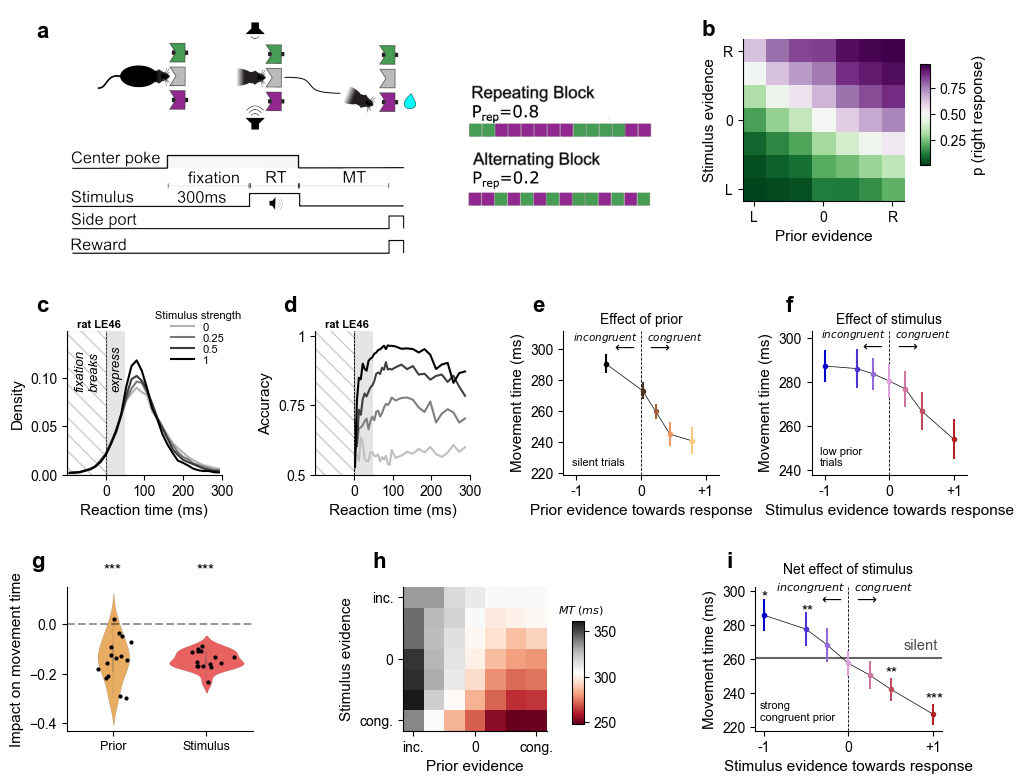

In [4]:
fig_1.fig_1_rats_behav(df_data=df, task_img=TASK_IMG, sv_folder=SV_FOLDER,
                        repalt_img=REPALT_IMG)

### Figure 2

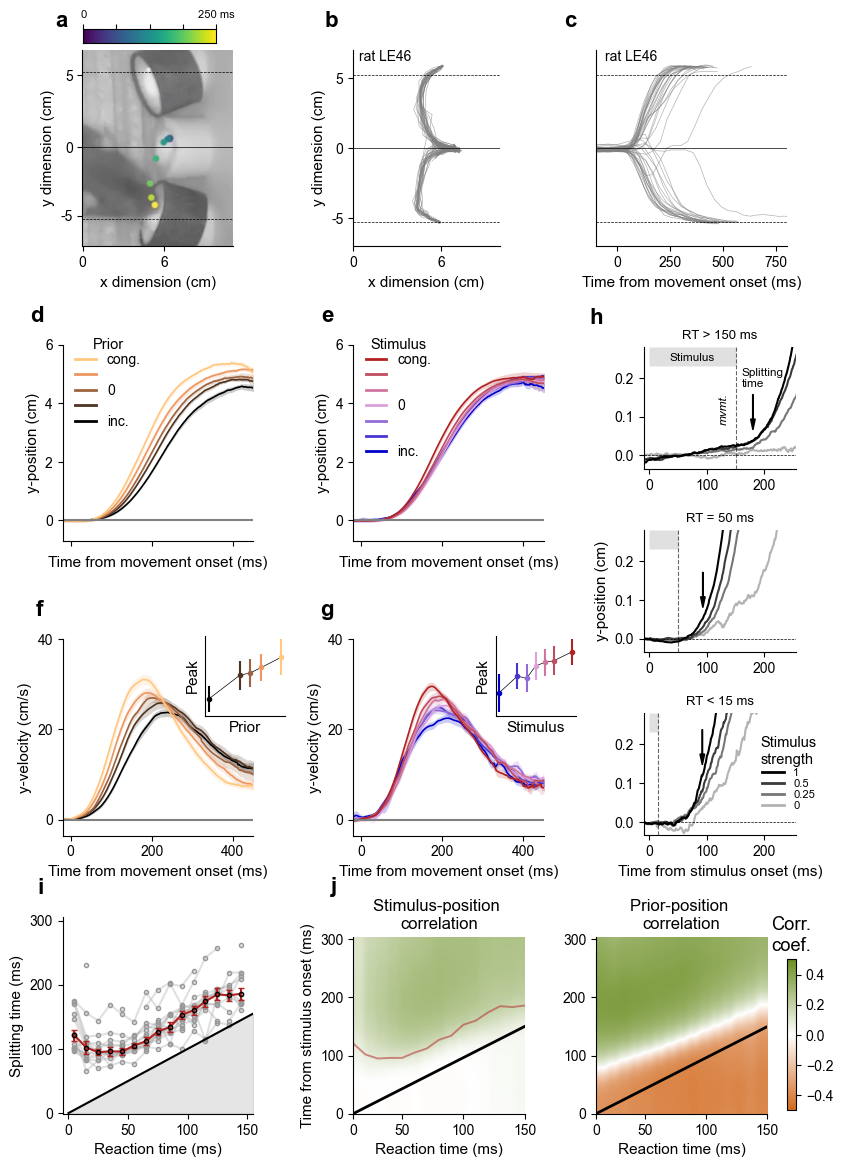

In [5]:
fig_2.fig_2_trajs(df=df.loc[df.soundrfail == 0], data_folder=DATA_FOLDER,
                  sv_folder=SV_FOLDER, rat_nocom_img=RAT_noCOM_IMG,
                  st_cartoon_img=ST_CARTOON_IMG)

### Figure 3

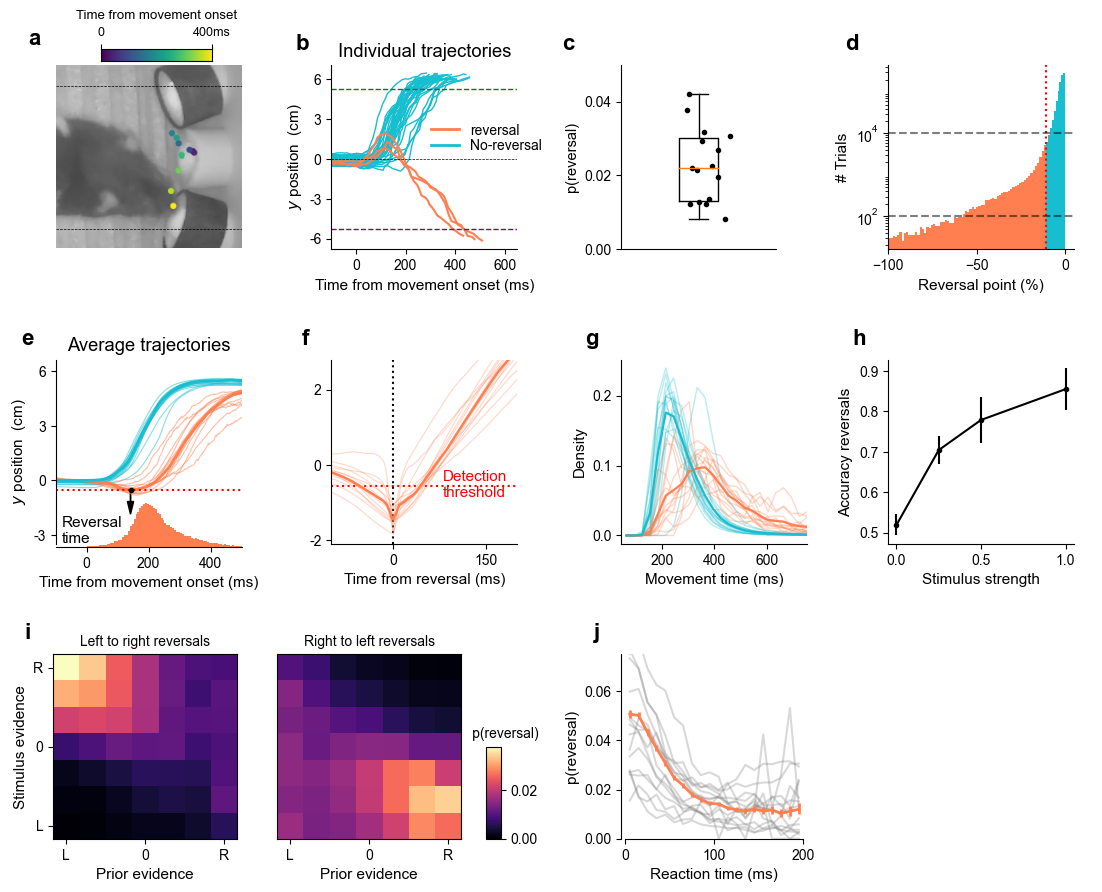

In [6]:
fig_3.fig_3_CoMs(df=df, sv_folder=SV_FOLDER, data_folder=DATA_FOLDER,
                     rat_com_img=RAT_COM_IMG)

### Figure 4

-----------
general_traj_all
14
[ 1.  4.  6.  7.  8. 10. 12. 13. 14. 15. 16. 17. 18. 21.]
[1785, 1675, 1604, 1557, 1725, 1489, 2575, 1645, 1794, 1446, 1449, 1816, 1655, 1666]


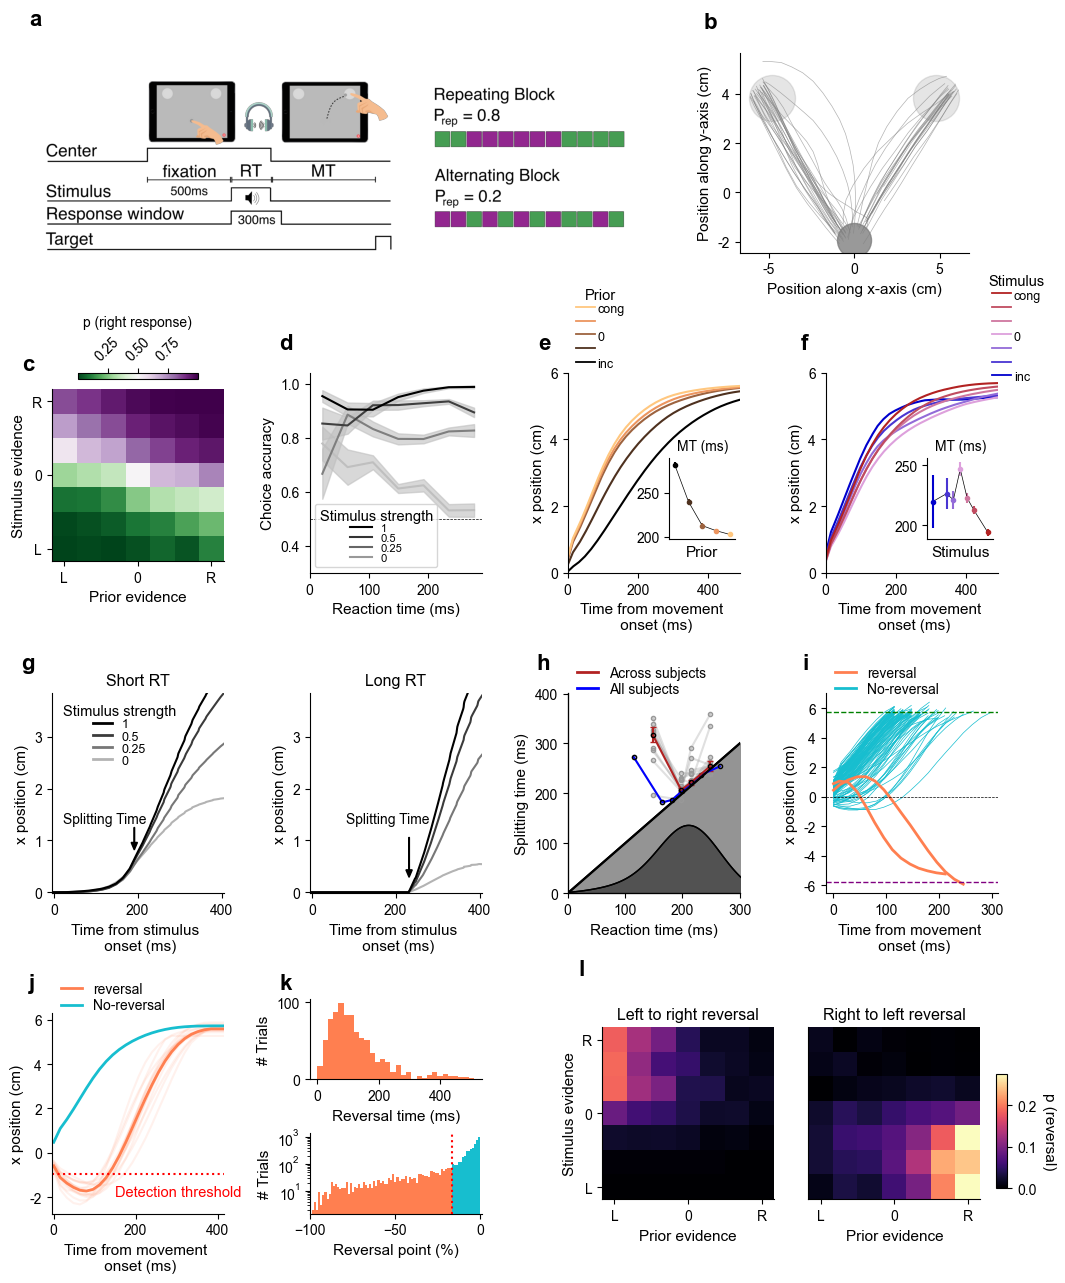

In [7]:
fig_6.fig_6_humans(user_id=pc_name, sv_folder=SV_FOLDER,
                    human_task_img=HUMAN_TASK_IMG, max_mt=1000, nm='300')

### Simulations and Figure 6

In [9]:
extra_label = ""  # to identify saved simulations
stim[df.soundrfail, :] = 0  # stimulus set to 0 when there was a hardware problem (failure in reproducing stimulus)
simulate = False  # if true, simulates even if there are simulations saved with extra_label name (overwrite)
# if false, doesn't simulate unless there aren't simulations saved with extra_label name
num_tr = int(len(df))
if stim.shape[0] != 20:
        stim = stim.T
print('Start simulating each rat with the corresponding parameters or Load already simmulated data')
hit_model, reaction_time, com_model_detected, resp_fin, com_model,\
            _, trajs, x_val_at_updt =\
            fp.run_simulation_different_subjs(stim=stim, zt=zt, coh=coh, gt=gt,
                                              trial_index=trial_index, num_tr=num_tr,
                                              subject_list=subjects, subjid=subjid, simulate=simulate,
                                              extra_label=extra_label)

Start simulating each rat with the corresponding parameters or Load already simmulated data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data


In [10]:
# build df_sim from simulated data
MT = [len(t) for t in trajs]
df_sim = pd.DataFrame({'coh2': coh, 'avtrapz': coh, 'trajectory_y': trajs,
                    'sound_len': reaction_time,
                    'rewside': (gt + 1)/2,
                    'R_response': (resp_fin+1)/2,
                    'resp_len': np.array(MT)*1e-3})
df_sim['CoM_sugg'] = com_model.astype(bool)
df_sim['traj_d1'] = [np.diff(t) for t in trajs]
df_sim['aftererror'] = np.array(df.aftererror)[:int(num_tr)]
df_sim['subjid'] = subjid
df_sim['origidx'] = trial_index
df_sim['special_trial'] = special_trial
df_sim['traj'] = df_sim['trajectory_y']
df_sim['com_detected'] = com_model_detected.astype(bool)
df_sim['peak_com'] = np.array(x_val_at_updt)
df_sim['hithistory'] = np.array(resp_fin == gt)
df_sim['soundrfail'] = df.soundrfail.values[:int(num_tr)]
df_sim['allpriors'] = zt
df_sim['norm_allpriors'] = fp.norm_allpriors_per_subj(df_sim)
df_sim['normallpriors'] = df_sim['norm_allpriors']
df_sim['framerate'] = 200
df_sim['res_sound'] = [st for st in stim.T]

In [11]:
# take fixation breaks out
df_sim = df_sim.loc[df_sim.sound_len.values >= 0]

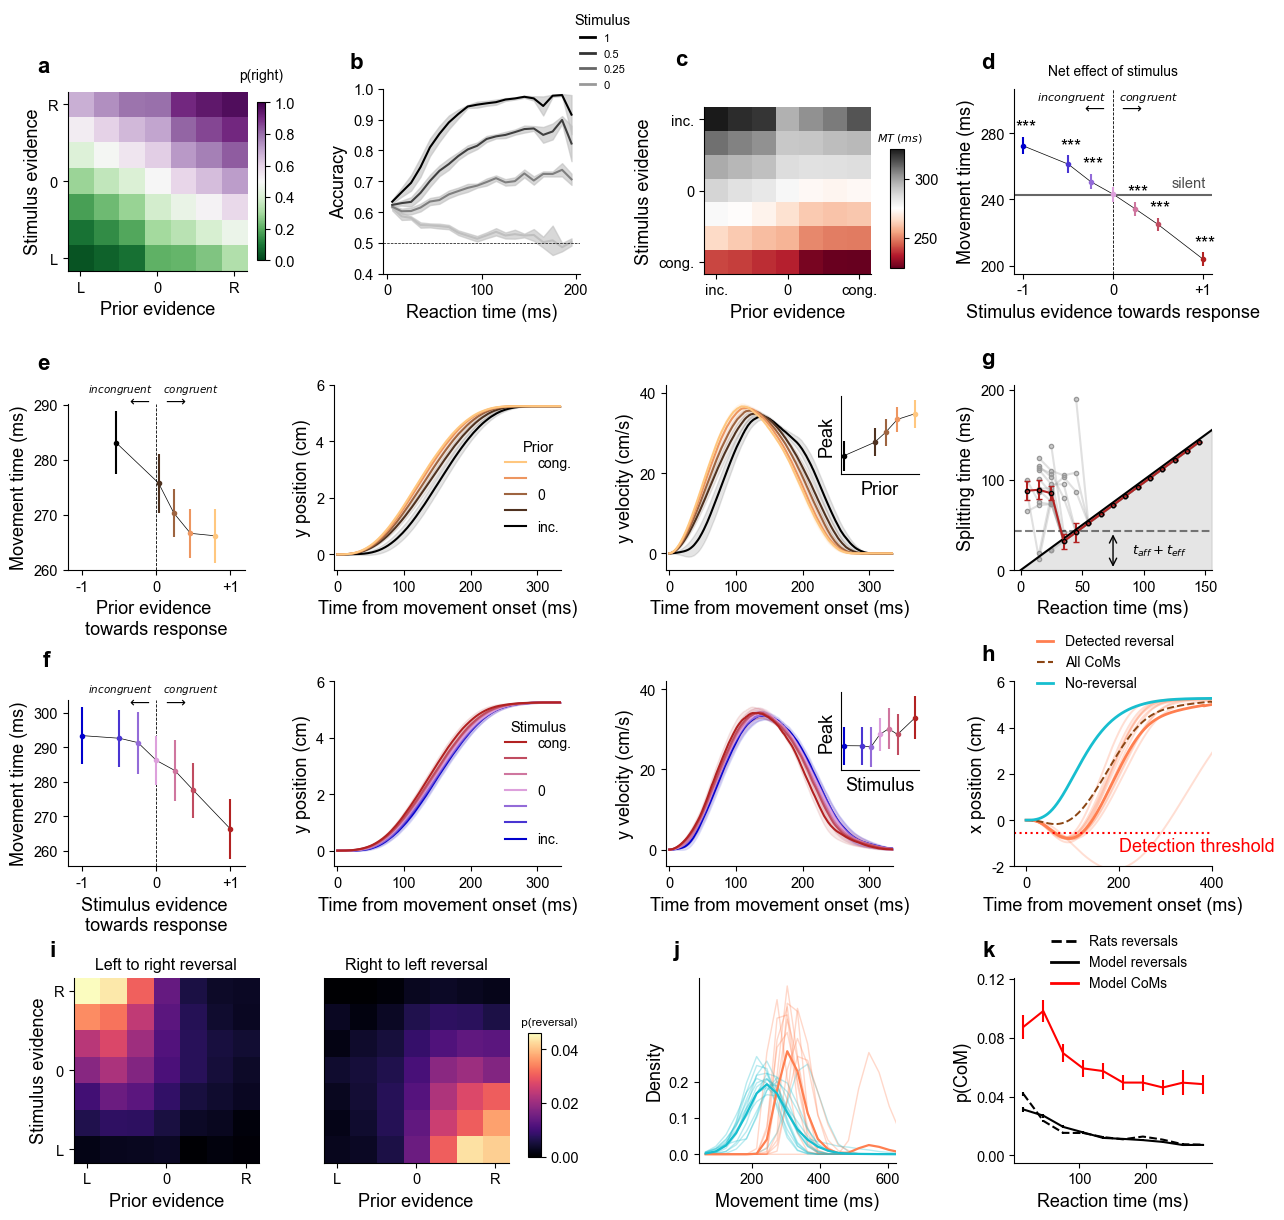

In [12]:
# save_new_data: bool, wether saving data for plots or not
save_new_data = False
fig_5.fig_5_model(sv_folder=SV_FOLDER, data_folder=DATA_FOLDER,
                  new_data=simulate, save_new_data=save_new_data,
                  coh=coh, sound_len=sound_len, zt=zt,
                  hit_model=hit_model, sound_len_model=reaction_time.astype(int),
                  decision_model=resp_fin, com=com, com_model=com_model,
                  com_model_detected=com_model_detected, df_sim=df_sim, extra_label=extra_label)

### Figure 7

Loading data
Loading data
Loading data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data
Loading simulated data


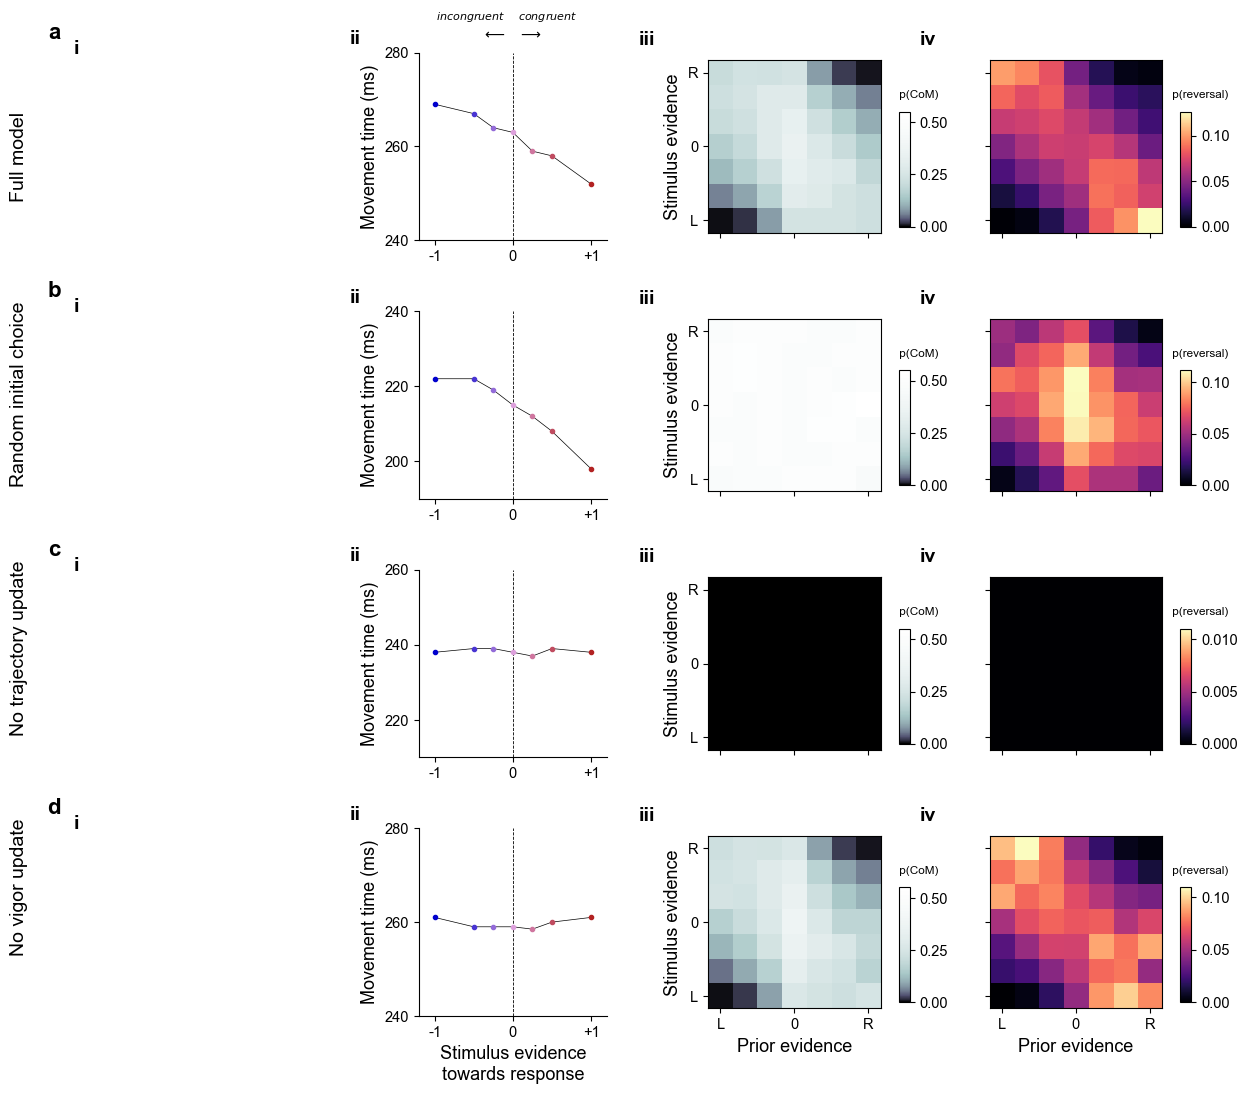

In [13]:
# take data from 3 rats, to get many different experimental conditions (stimulus, zt, trial_index):
subjects = ['LE42', 'LE38', 'LE39']
df_all = pd.DataFrame()
for sbj in subjects:
    df_7 = edd2.get_data_and_matrix(dfpath=DATA_FOLDER + sbj, return_df=True,
                                    sv_folder=SV_FOLDER, after_correct=True,
                                    silent=True, all_trials=True,
                                    srfail=True)
    df_all = pd.concat((df_all, df_7), ignore_index=True)
df_7 = df_all
del df_all
zt = np.nansum(df_7[["dW_lat", "dW_trans"]].values, axis=1)
df_7['allpriors'] = zt
hit = np.array(df_7['hithistory'])
stim = np.array([stim for stim in df_7.res_sound]).T
coh = np.array(df_7.coh2)
gt = np.array(df_7.rewside) * 2 - 1
trial_index = np.array(df_7.origidx)
special_trial = df_7.special_trial
df_7['subjid'] = 'LE42' # change to rat LE42 so that simulations are done with the same parameters
subjid = df_7.subjid.values
fig_7.fig_7(subjects, subjid, stim, zt, coh, gt, trial_index,
                    special_trial,
                    data_folder=DATA_FOLDER, sv_folder=SV_FOLDER,
                    extra_labels=[len(coh),
                                   '_2_ro_rand_'+str(len(coh)),
                                   '_1_ro_'+str(len(coh)),
                                  '_1_ro__com_modulation_'+str(len(coh)),
                                  ])

## Supplementary figures
### Supplementary figure 1

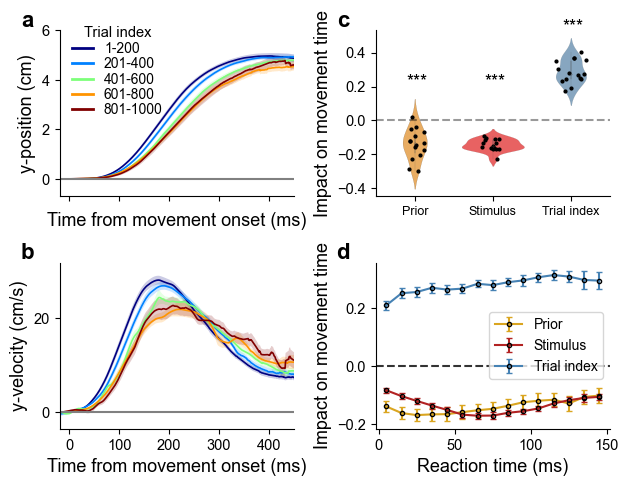

In [14]:
fig_1.supp_trial_index_analysis(df=df, data_folder=DATA_FOLDER,
                                sv_folder=SV_FOLDER)

### Supplementary figure 2

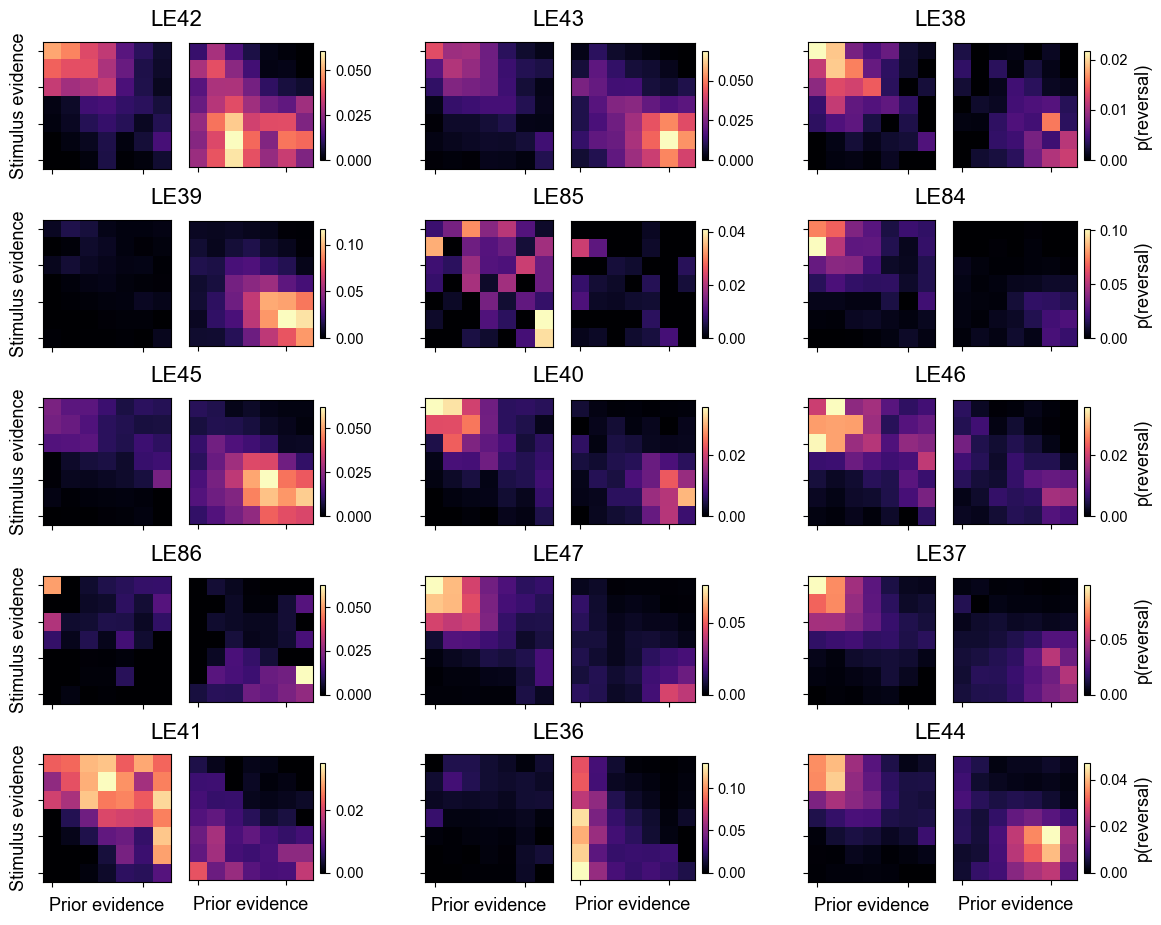

In [15]:
fig_3.supp_com_marginal(df=df, sv_folder=SV_FOLDER)

### Supplementary figure 3